In [1]:
%matplotlib inline

In [160]:
import numpy as np
import matplotlib.pyplot as plt
#import librosa
from scipy import fftpack
from scipy import signal
#from ipywidgets import interactive
#from IPython.display import Audio, display

# 592B, Class 6.2 (10/07/21).  Convolution

## Intro
Last time we said that windowing, filtering, and smoothing, are the same operations from a mathematical perspective. That operation is called **convolution**. The convolution of two functions $f(t)$ and $g(t)$ is defined as: 

$ f * g = \int_{-\infty}^{\infty} f(\tau)g(t-\tau)d\tau $

The motto that goes with this is: flip and shift and compute the overlapping area.

Here are some examples:

A rectangular pulse with itself:
![Animation box](https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif)


A rectangular pulse with itself, again:

![Animation rect](https://upload.wikimedia.org/wikipedia/commons/c/c6/Convolucion_Funcion_Pi.gif)

A rectangular pulse with a spiky function:
![Animation spiky](https://upload.wikimedia.org/wikipedia/commons/4/42/Convolucion_de_entrada_con_respuesta_al_impulso.gif)

A rectangular pulse with a spiky function, again:

![Animation spiky](https://upload.wikimedia.org/wikipedia/commons/6/67/Convolution_of_spiky_function_with_box.gif)


And a Gaussian with a Gaussian:

![Gaussian convolution](https://upload.wikimedia.org/wikipedia/commons/9/9c/Convolution_Animation_%28Gaussian%29.gif)

If we look at the [source code for the Gaussian window function scipy.signal.gaussian](https://github.com/scipy/scipy/blob/v1.0.0/scipy/signal/windows.py#L1159-L1219), it's basically just this (where $M$ is the window length):

```python

n = np.arange(0, M) - (M - 1.0) / 2.0
sig2 = 2 * std * std
w = np.exp(-n ** 2 / sig2)

```
And in the Elegant Scipy tutorial, the windowing happens with this:

```python

t = np.linspace(0, 1, 500)
x = np.sin(49 * np.pi * t)

X = fftpack.fft(x)
win = np.kaiser(len(t), 5)
X_win = fftpack.fft(x * win)

plt.plot(fftpack.fftfreq(len(t)), np.abs(X_win))
plt.ylim(0, 190);

```

As we noticed last time, the windowing is happening in the frequency domain, via plain multiplication, taking advantage of the Convolution Theorem: the Fourier transform of the convolution of two functions in the time domain is equivalent to the pointwise multiplication of the Fourier transforms of the two functions in the frequency domain: 

$$ \mathcal{F}(g \ast f)(s) = \mathcal{F}g(s)\mathcal{F}f(s)$$

Moreover, we can also show (see Osgood 2010 notes, p. 98):

$$ \mathcal{F}(gf)(s) = (\mathcal{F}g \ast \mathcal{F} f)(s) $$



## Review questions

1. Compute the convolution of a Gaussian function, using `np.convolve`. You can use the Gaussian window code above as a starting point.  What does the result look like? And what is the convolution of the result with itself?

2. Try to explain why there is an inverse relationship between window length and frequency resolution when you compute a spectrum (or spectrogram).


Sample code from [fft convolve docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html#scipy.signal.fftconvolve)

In [161]:
from scipy import misc

face = misc.face(gray=True)
kernel = np.outer(signal.windows.gaussian(70, 8),signal.windows.gaussian(70, 8))
blurred = signal.fftconvolve(face, kernel, mode='same')

/Users/oxbow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


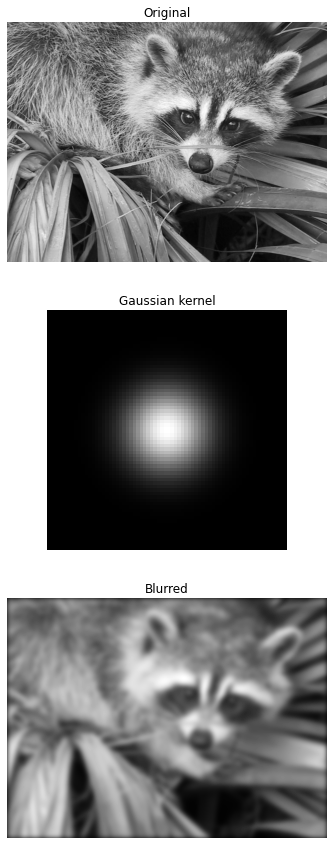

In [162]:
fig, (ax_orig, ax_kernel, ax_blurred) = plt.subplots(3, 1, figsize=(6, 15))

ax_orig.imshow(face, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()

ax_kernel.imshow(kernel, cmap='gray')
ax_kernel.set_title('Gaussian kernel')
ax_kernel.set_axis_off()

ax_blurred.imshow(blurred, cmap='gray')
ax_blurred.set_title('Blurred')
ax_blurred.set_axis_off()

fig.show()



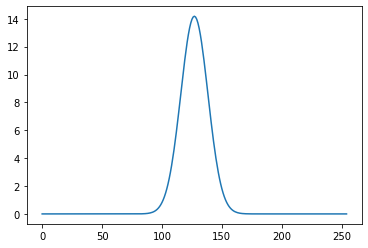

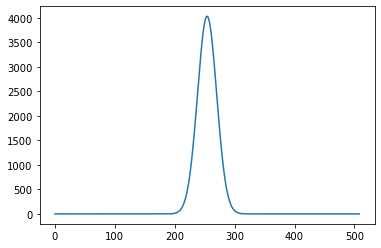

In [12]:
M = 128; std = 8
n = np.arange(0, M) - (M - 1.0) / 2.0
sig2 = 2 * std * std
w = np.exp(-n ** 2 / sig2)

w2 = np.convolve(w,w)

w4 = np.convolve(w2,w2)

plt.plot(w2)

plt.figure()
plt.plot(w4)


## Example of Convolution Theorem with digital convolution

In [164]:
 
x = np.array([5, 6, 8, 2, 5]) 
y = np.array([6, -1, 3, 5, 1])

x1 = np.concatenate((x, np.zeros(4)), axis=0)
y1 = np.concatenate((y, np.zeros(4)), axis=0)

c1 = fftpack.ifft(fftpack.fft(x1) * fftpack.fft(y1));
c2 = np.convolve(x,y);

print(c1)
print(c2)

[30.+0.00000000e+00j 31.-3.15796771e-15j 57.+3.15796771e-15j
 47.-3.41860033e-16j 87.-1.15589641e-15j 47.-1.57898386e-15j
 33.+3.41860033e-16j 27.+4.31386412e-15j  5.-1.57898386e-15j]
[30 31 57 47 87 47 33 27  5]


## Filters

The code below is adapted from this tutorial [signal filtering demo](https://www.swharden.com/wp/2009-01-21-signal-filtering-with-python/) (with some corrections).

The key point to get from this is to look at how filtering works from a frequency domain perspective, and to also see how that is related to what is going on in the time domain.

In [106]:
t_s = 0.01 # sampling interval
fs = 1/t_s # sampling rate
print("Sampling rate: ", fs, " Hz")

t = np.arange(1,100,t_s) 

f_sig = 0.3/(2*np.pi)   # frequency of signal   
f_n1 = 2.33/(2*np.pi)   # frequency of noise source 1
f_n2 = 2.77/(2*np.pi)    # frequency of noise source 2

print("Frequency of signal: ", f_sig, " Hz")
print("Frequency of electrical noise 1: ", f_n1, " Hz")
print("Frequency of electrical noise 2: ", f_n2, " Hz")

signal = np.sin(2*np.pi*f_sig*t) #(A)

sin_n1 = 0.333* np.sin(2*np.pi*f_n1*t) # (B) noise source 1
sin_n2 = 0.777* np.sin(2*np.pi*f_n2*t) # (B) noise source 2

noise = sin_n1 + sin_n2 # (C)  Combined noise sources

static = (np.random.random_sample((len(t)))-.5)*2 # (D)  Uniform distibution noise, 0.5 to 0.5

sigstat = static + signal # (E) Signal and static

rawsignal = sigstat + noise # (F) Signal + all sources of noise


Sampling rate:  100.0  Hz
Frequency of signal:  0.0477464829275686  Hz
Frequency of electrical noise 1:  0.37083101740411617  Hz
Frequency of electrical noise 2:  0.4408591923645501  Hz


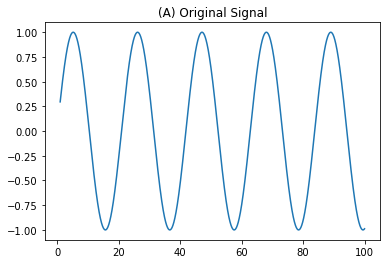

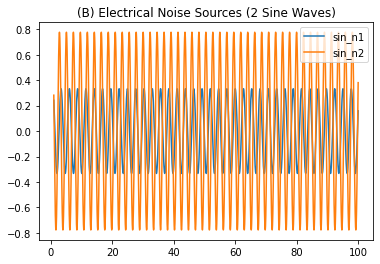

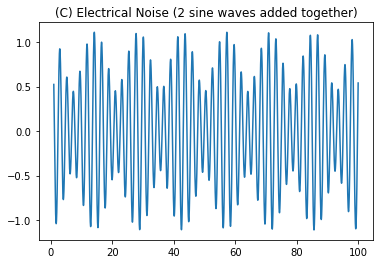

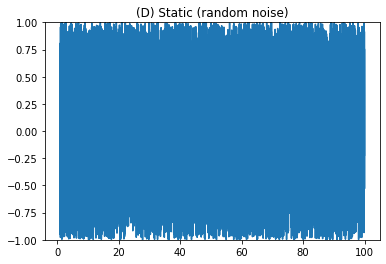

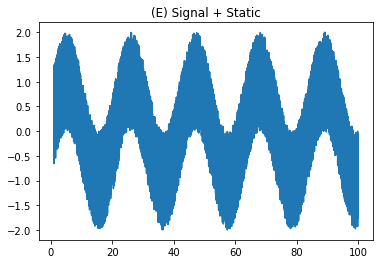

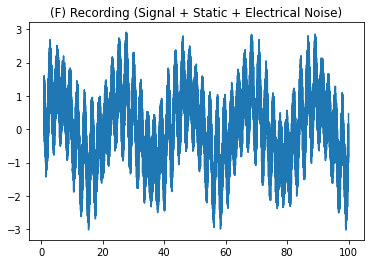

In [107]:
#pylab.subplot(h,w,1);pylab.title("(A) Original Signal")
plt.plot(t,signal)
plt.title("(A) Original Signal")
plt.show()


plt.title("(B) Electrical Noise Sources (2 Sine Waves)")
plt.plot(t,sin_n1,label="sin_n1")
plt.plot(t,sin_n2,label="sin_n2")
plt.legend()
plt.show()

plt.title("(C) Electrical Noise (2 sine waves added together)")
plt.plot(t,noise)
plt.show()

plt.title("(D) Static (random noise)")
plt.plot(t,static)
plt.axis([None,None,-1,1])
plt.show()

plt.title("(E) Signal + Static")
plt.plot(t,sigstat)
plt.show()

plt.title("(F) Recording (Signal + Static + Electrical Noise)")
plt.plot(t,rawsignal)

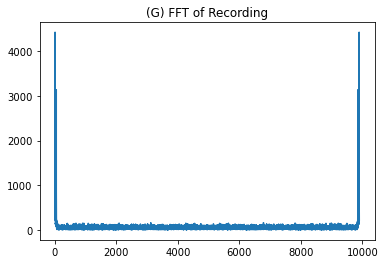

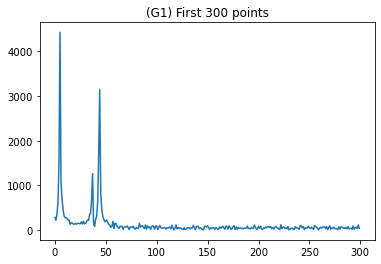

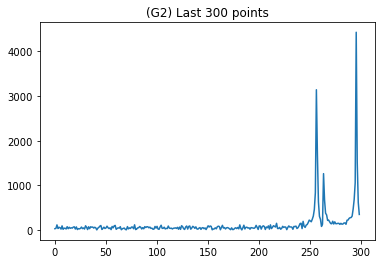

In [167]:
fft_sig = fftpack.fft(rawsignal) # (G) and (H)

plt.title("(G) FFT of Recording")
plt.plot(np.abs(fft_sig))

plt.figure()
plt.title("(G1) First 300 points")
plt.plot(np.abs(fft_sig)[0:300])

plt.figure()
plt.title("(G2) Last 300 points")
plt.plot(np.abs(fft_sig)[-300:-1])

(-50.0, 50.0, -220.6578336405987, 4648.521504706236)

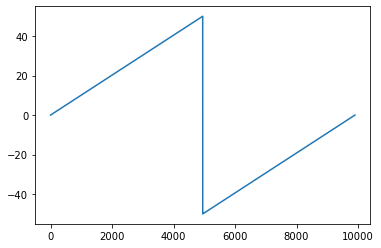

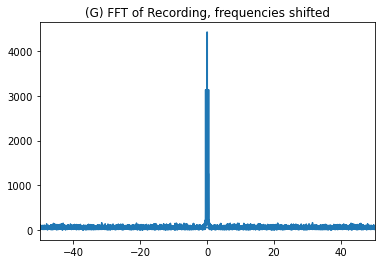

In [136]:
freqs = fftpack.fftfreq(len(rawsignal)) * fs
plt.plot(freqs)

plt.figure()
plt.title("(G) FFT of Recording, frequencies shifted")
plt.plot(freqs,np.abs(fft_sig))
plt.axis([-fs/2,fs/2,None,None])  # Why fs/2?

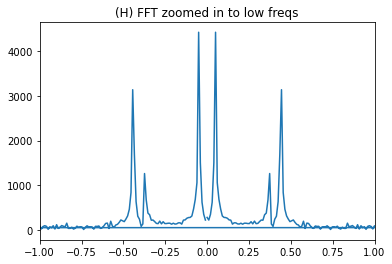

In [119]:
plt.title("(H) FFT zoomed in to low freqs")
plt.plot(freqs,np.abs(fft_sig))
plt.axis([-1,1,None,None])
plt.show()
# Where is the static? Try increasing amplitude of Gaussian noise (increasing variance)

Let's low pass filter to remove the static and noise sources.
The definition of a low pass filter that passes frequencies $s < \nu_c$ in the frequency domain is the following:

$$Low(s)  = \left\{
        \begin{array}{ll}
            1 & \quad \lvert s \rvert < \nu_c \\
            0 & \quad otherwise 
        \end{array}
         \right.$$ 

 So we need $\nu_c$ to be smaller than those noise sources. 

 ***What should we set $\nu_c$ to be?***         
 
Note also that this is just a scaled rect function, i.e., $$\Pi\left(\frac{s}{2\nu_c}\right)$$ and so in the time domain, we have:
 
 $$low(t) = 2\nu_c sinc(2\nu_ct)$$

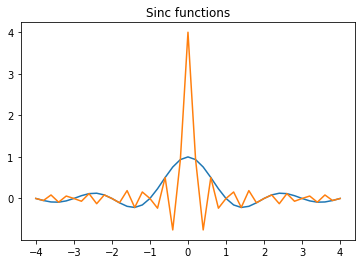

In [155]:
x = np.linspace(-4, 4, 41)
plt.plot(x,np.sinc(x))
plt.title("Sinc functions")

fc = 2  # set critical frequency

h = 2 * fc* np.sinc(2 * fc * x)
plt.plot(x,h)

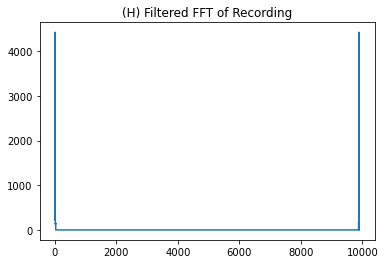

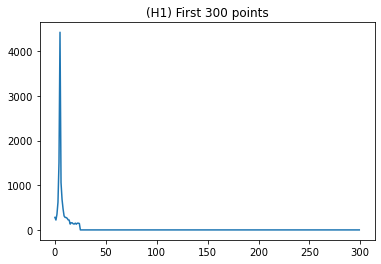

In [166]:
lowpass_filter = np.zeros(len(rawsignal))

# Set first 25 and last 25 values to 1
lowpass_filter[0:25] = 1
lowpass_filter[-25:-1] = 1

fil_fft_sig = fft_sig * lowpass_filter

plt.title("(H) Filtered FFT of Recording")
plt.plot(np.abs(fil_fft_sig))

plt.figure()
plt.title("(H1) First 300 points")
plt.plot(np.abs(fil_fft_sig)[0:300])


Now we can take the inverse Fourier transform to get back to the time domain!

/Users/oxbow/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


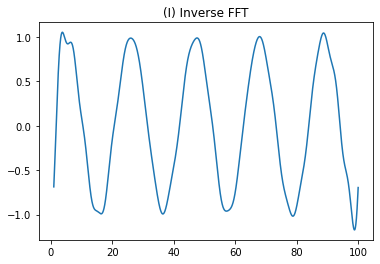

In [175]:
inv_fil_fft = fftpack.ifft(fil_fft_sig)
plt.title("(I) Inverse FFT")
plt.plot(t,inv_fil_fft)
plt.show()

## Time-limited signals and window length

Do the exercises I found [here](https://www.gaussianwaves.com/2011/01/fft-and-spectral-leakage-2/). Note that the code is in Matlab; you'll need to port to Python and modify as necessary.

Things to think about and answer:

- What causes spectral leakage?

## DFT and frequency/time trade-off

Remember that we ended up with the Fourier series of $g(t)$ defined as $T \rightarrow \infty$, expressed as a double integral:

\begin{equation}
g(t) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty}e^{-2\pi ift}g(t)dt e^{2\pi ift}df
\end{equation}

and then we derived $\mathcal{F}g$, where $\mathcal{F}g$ is defined as the Fourier transform of a function $g(t)$:

\begin{equation}
\mathcal{F}g = \int_{-\infty}^{\infty}e^{-2\pi ift} g(t)dt      
\end{equation}

and the inverse Fourier transform $\mathcal{F}^{-1}(t)$ of a function $\mathcal{F}g(f)$ is: 

\begin{equation}
g(t) = \int_{-\infty}^{\infty}e^{2\pi ift} \mathcal{F}gdf      
\end{equation}

Then we briefly introduced the **discrete Fourier transform (DFT)**: this is what we use when we're computing the Fourier Transform in python because we are working with *digital* signals. 



## The Discrete Fourier Transform

Today we're going to work on understanding the DFT a little more, because it will help us understand what's going on when we invoke `fftpack.fft`. The derivation here follows Osgood Chapter 6.

Our goal is to find a discrete version of $\mathcal{F}g(f)$, the Fourier transform of a function $g(t)$. (Note: by writing $\mathcal{F}g(f)$, we mean that the function $\mathcal{F}g$, the Fourier transform of $g(t)$, is a function of frequency, $f$. We start with $g(t)$, which is a function of time $t$, but once we take the Fourier transform of $g(t)$, $\mathcal{F}g$, we have a function of frequency $f$.). 

To do this, we need to find three things:
- A discrete version of $g(t)$ that reasonably approximates $g(t)$
- A discrete version of $\mathcal{F}g(f)$ that reasonably approximates $\mathcal{F}g(f)$
- A way in which these two discrete versions are related, which approximates the relation between the continuous versions

We start by assuming that $g(t)$ is:
- *time-limited*, meaning that $g(t)$ is zero outside of $0\leq t \leq L$, where $L$ is the length of the signal (in time)
- *band-limited*, meaning that $\mathcal{F}g(f)$ vanishes outside of $0 \lt f \lt 2B$, where $B$ is the *bandwidth* of the signal.


By the Sampling Theorem, if we sample $g(t)$ at the Nyquist rate of $2B$ samples/second, we can reconstruct $g(t)$ perfectly. This sampled version of $g(t)$, call it $g_{discrete}(t)$, is just a list of $N$ sampled values:

$$ g(t_0), g(t_1), \ldots, g(t_{N-1}) $$,

where $N=2BL$ and the timepoints are evenly spaced apart by $\frac{1}{2B}$.

***In-class exercise: Why is $N=2BL$ and why does $\Delta t_n = \frac{1}{2B}$?***

---


### The Dirac comb

We can re-express $g_{discrete}(t)$ using the Dirac comb $III(t)$, defined as:

$$III(t) = \displaystyle\sum_{n=0}^{N-1} \delta(t-t_n) $$

All this is is a "train" of pulses, a comb of "lollipops" with amplitude 1, where the pulses occur exactly at the sampled points $t_0, t_1, \ldots, t_{N-1}$.

Here's an image of a Dirac comb from Wikipedia. In our case, $T = 1/2B$.

<img alt = "Dirac comb plot" src="https://upload.wikimedia.org/wikipedia/commons/4/49/Dirac_comb.svg" width="300"  />


And here's an example of [one way to define a Dirac comb function](https://scipython.com/book/chapter-6-numpy/examples/a-comb-function/), from [scipython.com](https://scipython.com).


In [4]:
N, n = 101, 5
def f(i):
    return (i % n == 0) * 1

comb = np.fromfunction(f, (N,), dtype=int)
print(comb)


[1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1]


***In-class discussion: Does the Dirac comb form an orthogonal basis set?***

---

Using $III(t)$, we can now express $g_{discrete}(t)$ as:

$$g_{discrete}(t) = g(t) \displaystyle\sum_{n=0}^{N-1} \delta(t-t_n) = \displaystyle\sum_{n=0}^{N-1} g(t) \delta(t-t_n) $$

And the Fourier transform of $g_{discrete}(t)$ is:

\begin{equation}
\mathcal{F}g_{discrete}(f) = \displaystyle\sum_{n=0}^{N-1} = \mathcal{F}g(t_n) \delta(t-t_n) = \displaystyle\sum_{n=0}^{N-1} g(t_n) e^{-2\pi ift_n}      
\end{equation}

This gives us the continuous Fourier transform of the sampled version of $g(t)$.

Now let's think about $g(t)$ in the frequency domain. Remember by assumption that $g(t)$ is time-limited so $g(t)$ is zero outside of $0\leq t \leq L$, where $L$ is the length of the signal (in time). So we can apply the Sampling Theorem to reconstruct $\mathcal{F}g(f)$ in the frequency domain. The sampling rate we need (the Nyquist rate) for perfect reconstruction is $L$ samples/Hz and the spacing between sampling points is $1/L$.

Since $\mathcal{F}g(f)$ is band-limited by assumption and  vanishes outside of $0 \lt f \lt 2B$, we sample $\mathcal{F}g(f)$ over $0 \lt f \lt 2B$, with points $1/L$ Hz apart. 

---

***In-class exercise: Why is the sampling rate $L$ samples/Hz and why is the interval between sampling points $1/L$ Hz? What is the total number of sampling points, $N$***

---

This sampled version of $\mathcal{F}g(f)$, call it $\mathcal{F}g_{discrete}(f)$, is just a list of $N$ sampled values, of the form $m/L$, where $m$ is a non-negative integer:

$$ f_0=0,\, f_1 = \frac{1}{L},\, \ldots, f_{N-1} = \frac{N-1}{L} $$,

And if we want the discrete version of $g_{discrete}(t)$, then we want to take $[\mathcal{F}(g_{discrete})](f)$, call this $F(f)$ for short.

Taking our definition of the Fourier transform of $g_{discrete}(t)$,

$$\mathcal{F}g(t_n) \delta(t-t_n) = \displaystyle\sum_{n=0}^{N-1} g(t_n) e^{-2\pi ift_n}$$

this will give us the list:

$$ F(f_0) = \displaystyle\sum_{n=0}^{N-1} g(t_n) e^{-2\pi if_0t_n}, \ldots, F(f_{N-1})=\displaystyle\sum_{n=0}^{N-1} g(t_n) e^{-2\pi if_{N-1}t_n}  $$

And so now we have a way to go from $g_{discrete}(t)$ to $\mathcal{F}g_{discrete}(f)$, for each $m$ from $m=0$ to $m=N-1$:

$$F(f_m) = \displaystyle\sum_{n=0}^{N-1} g(t_n) e^{-2\pi if_mt_n} $$

Recalling that $t_n = \frac{n}{2B}$ and $f_m = \frac{m}{L}$ and $N=2BL$, we can re-write this as:

$$F(f_m) = \displaystyle\sum_{n=0}^{N-1} g(t_n) e^{-2\pi inm/N} $$

***In-class exercise: derive our final expression of $F(f_m)$.***

---

At this point, let's come back to one of our starting questions and discuss. You should have more insight on this now! What is the "grid" spacing in the time-domain? The frequency domain? How are they related? 

> Why is the computation of the spectrum affected by the "window length" over which it is computed, and how is it affected?

---

## Positive and negative frequencies (Osgood 2010, p. 260)

Given our discrete Fourier transform $[\mathcal{F}(g_{discrete})](f)$, call this $F(f)$:

$$F(f_m) = \displaystyle\sum_{n=0}^{N-1} g(t_n) e^{-2\pi inm/N} $$

it turns out that the spectrum *splits* at $N/2$. See Osgood (2010) for the derivation, but due to some periodicity relations:

$$ F[\frac{N}{2} + 1] = \overline{F[\frac{N}{2} - 1]}$$ 
$$ F[\frac{N}{2} + 2] = \overline{F[\frac{N}{2} - 2]}$$ 
$$ \vdots$$

***In-class exercise: What is F[0]? What do the periodicity relations mean geometrically?***

So because of this, the convention is to say, for a spectrum indexed from 0 to $N-1$:
- The frequencies from $m=1$ to $m= N/2-1$ are the "positive" frequencies
- The frequencies from $m=N/2+1$ to $m= N-1$ are the "negative" frequencies

For a real signal, all the information you need is in the positive frequencies and the first component $F[0]$.

